In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as utils
from torchvision import transforms, models
import pretrainedmodels
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.nn.functional as F
import time
import os
import copy

In [2]:
is_cuda = torch.cuda.is_available()
is_cuda

True

In [3]:
def extract_patches_2d(img,patch_shape,step=[1.0,1.0],batch_first=False):
    patch_H, patch_W = patch_shape[0], patch_shape[1]
    if(img.size(2)<patch_H):
        num_padded_H_Top = (patch_H - img.size(2))//2
        num_padded_H_Bottom = patch_H - img.size(2) - num_padded_H_Top
        padding_H = nn.ConstantPad2d((0,0,num_padded_H_Top,num_padded_H_Bottom),0)
        img = padding_H(img)
    if(img.size(3)<patch_W):
        num_padded_W_Left = (patch_W - img.size(3))//2
        num_padded_W_Right = patch_W - img.size(3) - num_padded_W_Left
        padding_W = nn.ConstantPad2d((num_padded_W_Left,num_padded_W_Right,0,0),0)
        img = padding_W(img)
    step_int = [0,0]
    step_int[0] = int(patch_H*step[0]) if(isinstance(step[0], float)) else step[0]
    step_int[1] = int(patch_W*step[1]) if(isinstance(step[1], float)) else step[1]
    patches_fold_H = img.unfold(2, patch_H, step_int[0])
    if((img.size(2) - patch_H) % step_int[0] != 0):
        patches_fold_H = torch.cat((patches_fold_H,img[:,:,-patch_H:,].permute(0,1,3,2).unsqueeze(2)),dim=2)
    patches_fold_HW = patches_fold_H.unfold(3, patch_W, step_int[1])   
    if((img.size(3) - patch_W) % step_int[1] != 0):
        patches_fold_HW = torch.cat((patches_fold_HW,patches_fold_H[:,:,:,-patch_W:,:].permute(0,1,2,4,3).unsqueeze(3)),dim=3)
    patches = patches_fold_HW.permute(2,3,0,1,4,5)
    patches = patches.reshape(-1,img.size(0),img.size(1),patch_H,patch_W)
    if(batch_first):
        patches = patches.permute(1,0,2,3,4)
    return patches

# Utiles

In [11]:
#misclassified된 이미지들을 저장하는 함수
def misimshow(inp,name,index):
    inp = inp.transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title('misclassified as %s' %(name))
    #plt.savefig('D:/capstone/split_patient/S4/Output/misclassified_test/4fold/%d.jpg'%(index))

#각 set의 개수는 용도로 쓰이는 함수(단, 시간이 오래걸려 사용안함)
def num_of_label(loader):
    global n
    label_list = []
    n=0
    while n < len(loader):
        if loader == trainloader.dataset:
            set = 'Train set'
            label_lists = np.array(train[n][1])
            label_list = np.append(label_list,label_lists)
            n+=1
        elif loader == validloader.dataset:
            set = 'Valid set'
            label_lists = np.array(valid[n][1])
            label_list = np.append(label_list,label_lists)
            n+=1
        elif loader == testloader.dataset:
            set = 'Test set'
            label_lists = np.array(test[n][1])
            label_list = np.append(label_list,label_lists)
            n+=1
    unique, counts = np.unique(label_list, return_counts=True)
    print('{} : {}'.format(set,dict(zip(unique, counts))))

#결과의 accuracy나 loss변화를 보는 그래프
def result_graph():
    plt.figure(1)
    
    plt.subplot(2,1,1)
    plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'b',label = 'train accuracy')
    plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'valid accuracy')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.title('Acc Curve')
    plt.legend()
    plt.subplots_adjust(hspace=0.7)
    
    plt.subplot(2,1,2)
    plt.plot(range(1,len(train_losses)+1),train_losses,'b',label = 'train loss')
    plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'valid loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss Curve')
    plt.legend()

#학습시 일정 주기(patience)동안 가장 낮은 로스 기준으로 더 낮은 로스가 나타나지 않으면 조기 학습종료
class EarlyStopping():
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience  = patience
        self.verbose = verbose
 
    def validate(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print('Training process is stopped early....')
                return True
        else:
            self._step = 0
            self._loss = loss
 
        return False

#전체적인 result값을 구하고 분석하는 VAlid와 Test시에 사용
def confmat(loader):
    #확인하려는 모델을 부름
    model.load_state_dict(torch.load('s3_1fold_1reapeated.pt'))
    model.eval()
    volatile=True
    running_correct = 0
    nb_classes = 2
    index = 0
    #패치를 위해 인풋영상을 299*299에서 upsampling하기 위해 만듬
    up_sample = nn.UpsamplingBilinear2d(size=(478, 478))
    roc_max_diff, roc_target = [],[]

    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    #테스트단에서 grad를 사용하지 않으므로
    with torch.no_grad():
        #data와 target을 들어온 loader에서 받음
        for data,target in loader:
            inputs,target = data.cpu(),target.cpu()
            if loader == validloader:
                if is_cuda:
                #원본에 대한 결과값
                    inputs_original = data.cuda()
                inputs_original = Variable(inputs_original)
                outputs_original = model(inputs_original)
                outputs_original = torch.sigmoid(outputs_original)
                
                inputs = up_sample(inputs)
                #인풋이미지에대해 overlapping patch로 4개의 패치를 만듬 파라메터로는 inputs가 인풋 영상이고 [299,299]는
                #실제로 받을 패치들의 사이즈, step은 가로 세로 stride이며, batch_first란 4D에서 5D의 결과값이 나올떄 batch 차원을 제일 앞에 두는 변수
                img = extract_patches_2d(inputs,[299,299],step=[0.6,0.6],batch_first=True)
                length = len(target)
                if is_cuda:
                    img,target = img.cuda(),target.cuda()
                img , target = Variable(img),Variable(target)
                for i in range(length):
                    outputs = model(img[i])
                    outputs = torch.sigmoid(outputs)
                   
                #원본 + 패치들의 값들을 더하기
                    for j in range(4):
                        outputs_original[i,0] += outputs[j,0]
                        outputs_original[i,1] += outputs[j,1]
                    #평균을 내줌 즉, TTA(Test time augmentation)    
                    outputs_original[i] = outputs_original[i]/5
                    
                #BN과 ALM에 대한 확률중 가장 큰값을 인덱스로 택함
                _, preds = torch.max(outputs_original, 1)
                running_correct += preds.eq(target.data.view_as(preds)).cpu().sum() 
                
                
                        
            if loader == testloader:
                if is_cuda:
                #원본에 대한 결과값
                    inputs_original = data.cuda()
                inputs_original = Variable(inputs_original)
                outputs_original = model(inputs_original)
                outputs_original = torch.sigmoid(outputs_original)
                
                inputs = up_sample(inputs)
                #인풋이미지에 의해 패치를 만드는단 
                img = extract_patches_2d(inputs,[299,299],step=[0.6,0.6],batch_first=True)
                length = len(target)
                if is_cuda:
                    img,target = img.cuda(),target.cuda()
                img , target = Variable(img),Variable(target)
                for i in range(length):
                    outputs = model(img[i])
                    outputs = torch.sigmoid(outputs)
                   
                #원본 + 패치들의 값들을 더하기
                    for j in range(4):
                        outputs_original[i,0] += outputs[j,0]
                        outputs_original[i,1] += outputs[j,1]
                   #원본과 패치들의 값을 다 더한후 평균 내주기     
                    outputs_original[i] = outputs_original[i]/5
                    #ROC curve를 그리기위해 평균낸 값에서 ALM인 부분의 확률을 쌓음
                    roc_max_diff = np.append(roc_max_diff,outputs_original[i,1])
                load_original_preds = outputs_original.cpu()
                load_original_preds = load_original_preds.numpy()
                np.savetxt(output_path + "load_original_preds.csv", load_original_preds)
                _, preds = torch.max(outputs_original, 1)
                load_preds = preds.cpu()
                load_preds = load_preds.numpy()
                np.savetxt(output_path + "load_preds.csv", load_preds)
                preds,target,inputs = preds.cpu(),target.cpu(),inputs.cpu()

                #mpreds,mtarget,minputs = preds.numpy(),target.numpy(),inputs.numpy()
                #for m in range(len(mpreds)):
                 #   index = index +1
                  #  o = (mpreds[m]==mtarget[m]).astype(np.float32)
                   # if o != 1:
                    #    mis = mpreds[m]
                     #   if mis != 0:
                      #      name = 'melanoma'
                       # else:
                        #    name = 'benign'        
                        #misimshow(minputs[m],name,index)
                running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
                #ROC커브를 그리기위해 실제 정답값을 쌓음
                roc_target = np.append(roc_target,target)
            
            #결과를 분석하기 위해 사이킷런 기반confusion_matrix 함수를 사용 
            if loader == validloader:
                for t, p in zip(target.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
            if loader == testloader:   
                for t, p in zip(target.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
                    
        #가지고 있는 Set에 대한 평균 정확도를 측정
        accuracy = 100. * running_correct/len(loader.dataset)
                    
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            s[i][j] = confusion_matrix[i][j]
    TN,FP,FN,TP = s[0][0],s[0][1],s[1][0],s[1][1]
    PE = ((TP+FN)/(len(loader.dataset)))*((TP+FP)/(len(loader.dataset)))+((FP+TN)/(len(loader.dataset)))*((FN+TN)/(len(loader.dataset)))
    print(confusion_matrix)
    print(confusion_matrix.diag()/confusion_matrix.sum(1))
    print('TP = {}, FP = {}, TN = {}, FN = {}'.format(TP,FP,TN,FN))
    print('Specifity = {:.4f}, Sensitivity = {:.4f}'.format(TN/(TN+FP),TP/(TP+FN)))
    print('F1 score = {:.4f}'.format(TP/(TP+(FN+FP)/2)))
    if loader == testloader:
        print('Test Acc = {:.4f}'.format(accuracy))
        accuracy = accuracy.type(torch.FloatTensor)
        PE = PE.type(torch.FloatTensor)
        Kappa = (0.01*accuracy-PE)/(1.0-PE)
        Kappa = Kappa.type(torch.FloatTensor)
        print('cohens kappa = {:.4f}'.format(Kappa))
        #roc커브를 그리기위해 사용하는 사이킷런기반의 roc_curve함수
        fpr, tpr, _ = roc_curve(roc_target,roc_max_diff)
        roc_auc = auc(fpr,tpr)
        np.save(output_path + "fpr.npy", fpr)
        np.save(output_path + "tpr.npy", tpr)
        np.save(output_path + "auc.npy", roc_auc)
        np.save(output_path + "roc_target.npy", roc_target)
        np.save(output_path + "roc_max_diff.npy", roc_max_diff)

# Network

In [5]:
fine_tune = False
model = models.resnet50(pretrained=True)

if not fine_tune:
    for parameter in model.parameters():
        parameter.requires_grad = False

n_features = model.fc.in_features
model.dropout = nn.Dropout(p=0.5)
model.fc = nn.Linear(n_features, 2)

if torch.cuda.is_available():
    model = model.cuda()

In [6]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [7]:
learning_rate = 0.1
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=learning_rate,momentum=0.9,nesterov=True)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [8]:
#학습단에서 사용하는 fit함수로 confmat과 비슷함 단 여기서는 train,과 valid만 있음 정해진 에폭마다 반복시행
def fit(epoch,model,data_loader,phase='train',volatile=False):
    if phase == 'train':
        exp_lr_scheduler.step()
        model.train()
    if phase == 'valid':
        model.eval()

    running_loss = 0.0
    running_correct = 0
    up_sample = nn.UpsamplingBilinear2d(size=(478, 478))
    for batch_idx , (data,target) in enumerate(data_loader):
        inputs,target = data.cpu(),target.cpu()
        if phase == 'valid':
            with torch.no_grad():
                if is_cuda:
            #원본에 대한 결과값
                    inputs_original = data.cuda()
                inputs_original = Variable(inputs_original)
                outputs_original = model(inputs_original)
                outputs_original = torch.sigmoid(outputs_original)
                inputs = up_sample(inputs)
                img = extract_patches_2d(inputs,[299,299],step=[0.6,0.6],batch_first=True)
                length = len(target)
                if is_cuda:
                    img,target = img.cuda(),target.cuda()
                img , target = Variable(img),Variable(target)
                for i in range(length):
                    outputs = model(img[i])
                    outputs = torch.sigmoid(outputs)
                   
                #원본 + 패치들의 값들을 더하기
                    for j in range(4):
                        outputs_original[i,0] += outputs[j,0]
                        outputs_original[i,1] += outputs[j,1]
                        
                    outputs_original[i] = outputs_original[i]/5
                    
                loss = criterion(outputs_original,target)  
                running_loss += loss.data.item()
                _, preds = torch.max(outputs_original, 1)
                running_correct += preds.eq(target.data.view_as(preds)).cpu().sum() 
        
        if phase == 'train':
            if is_cuda:
                inputs,target = data.cuda(),target.cuda()
            inputs , target = Variable(inputs,volatile),Variable(target)
            optimizer.zero_grad()
            
         
            output = model(inputs)
            loss = criterion(output,target)  
            running_loss += loss.data.item()
            preds = output.data.max(dim=1,keepdim=True)[1]
            running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'train':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)
    
    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, loss, accuracy))
    return loss,accuracy

# DATA SET MAKING and TRAIN 


Epoch 0/399
----------
train Loss: 0.3257 Acc: 77.0000


C:\Users\yonsei\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
C:\Users\yonsei\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


valid Loss: 0.0467 Acc: 53.0000
0.04671147093176842

inf

0

Epoch 1/399
----------
train Loss: 0.2475 Acc: 82.0000
valid Loss: 0.0232 Acc: 95.0000
0.023154059424996376

0.04671147093176842

0

Epoch 2/399
----------
train Loss: 0.2174 Acc: 83.0000
valid Loss: 0.0252 Acc: 90.0000
0.02515811212360859

0.023154059424996376

0

Epoch 3/399
----------
train Loss: 0.1902 Acc: 85.0000
valid Loss: 0.0259 Acc: 88.0000
0.025942481122910976

0.023154059424996376

1

Epoch 4/399
----------
train Loss: 0.1900 Acc: 85.0000
valid Loss: 0.0273 Acc: 90.0000
0.027285075560212136

0.023154059424996376

2

Epoch 5/399
----------
train Loss: 0.1805 Acc: 86.0000
valid Loss: 0.0253 Acc: 89.0000
0.025318210013210773

0.023154059424996376

3

Epoch 6/399
----------
train Loss: 0.1612 Acc: 86.0000
valid Loss: 0.0233 Acc: 95.0000
0.023271507397294045

0.023154059424996376

4

Epoch 7/399
----------
train Loss: 0.1988 Acc: 86.0000
valid Loss: 0.0292 Acc: 85.0000
0.029178364016115666

0.023154059424996376

5

Epo

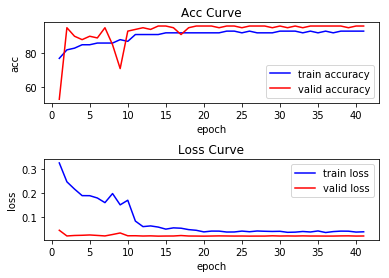

In [9]:
#배치사이즈
batch_size = 16
#에폭 정하기
num_epochs = 400

#결과 값들을 받을 주소 설정
output_path = 'D:/capstone/split_patient/S3/Output/ROC_1/'
#이미지들을 리사이즈하고 텐서로 바꾸며, 이미지넷에서 학습된 아키텍처를 사용하므로 노멀라이즈 해줌
transform = transforms.Compose([transforms.Resize((299,299))
                                       ,transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

transforms = transforms.Compose([transforms.Resize((478,478))
                                       ,transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
#주소에서 트랜스폼하여 폴더를 받아오고 그뒤 데이터로더로 묶어줌
train = ImageFolder('D:/capstone/split_patient/S3/data/1fold/train',transform=transform)
trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=5, pin_memory=True)

valid = ImageFolder('D:/capstone/split_patient/S3/data/1fold/valid',transform=transforms)
validloader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=True, num_workers=5, pin_memory=True)

test = ImageFolder('D:/capstone/split_patient/raw data/test',transform=transforms)
testloader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True, num_workers=5, pin_memory=True)


#K-Fold시 매 Fold당 초기 상태로 시작하기 위해 사용 (우리의 학습에는 사용하지 않음)
init_state = copy.deepcopy(model.state_dict())
init_state_opt = copy.deepcopy(optimizer.state_dict())
init_state_lr = copy.deepcopy(exp_lr_scheduler.state_dict())


#학습 시간을 재기위해
since = time.time()
#avg val 로스와 정확도를 위한 변수설정
avg_val_losses, avg_val_accuracy = [],[]
#얼리 스탑기능을 사용하기 위해
early_stopping = EarlyStopping(patience=20, verbose=1)


#K-Fold시 매 Fold당 초기 상태로 시작하기 위해 사용 (우리의 학습에는 사용하지 않음)
model.load_state_dict(init_state)
optimizer.load_state_dict(init_state_opt)
exp_lr_scheduler.load_state_dict(init_state_lr)


train_losses, train_accuracy = [],[]
val_losses, val_accuracy = [],[]
    
 
     
#학습시 에폭을 반복하기위해
for epoch in range(num_epochs):
    print()
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
    #fit에서 학습시 한 에폭의 결과값을 받음
    epoch_loss, epoch_accuracy = fit(epoch,model,trainloader,phase='train')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,model,validloader,phase='valid')
    
    #받은 값들을 전 에폭에서의 값들에 이어 붙임
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    
    # 얼리스탑 기능을 사용 만약 output값이 True면 for문 break
    if early_stopping.validate(val_epoch_loss):
        break

avg_val_losses = val_losses
avg_val_accuracy = val_accuracy
#정해진 이름으로 모델을 저장하는 단
torch.save(model.state_dict(),'s2-s3_1fold.pt')

print()
#confmat에서 결과 분석
confmat(validloader)
result_graph()
    
time_elapsed = time.time() - since
print()
avg_val_accuracy, avg_val_losses = sum(avg_val_accuracy), sum(avg_val_losses)
avg_val_accuracy, avg_val_losses = np.average(avg_val_accuracy), np.average(avg_val_losses)
print('Avg valid Loss: {:.4f} Acc: {:.4f}'.format(
                avg_val_losses, avg_val_accuracy))
print('Training complete in {:.0f}m {:.0f}s'.format(
time_elapsed // 60, time_elapsed % 60))



batch_size = 16
num_epochs = 400

output_path = 'D:/capstone/split_patient/S3/Output/ROC_1/'
transform = transforms.Compose([transforms.Resize((299,299))
                                       ,transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

transforms = transforms.Compose([transforms.Resize((478,478))
                                       ,transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train = ImageFolder('D:/capstone/split_patient/S3/data/1fold/train',transform=transform)
trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=5, pin_memory=True)

valid = ImageFolder('D:/capstone/split_patient/S3/data/1fold/valid',transform=transforms)
validloader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=True, num_workers=5, pin_memory=True)

test = ImageFolder('D:/capstone/split_patient/raw data/test',transform=transforms)
testloader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True, num_workers=5, pin_memory=True)



In [10]:
#test셋의 결과 분석
confmat(testloader)

tensor([[86., 14.],
        [ 9., 91.]])
tensor([0.8600, 0.9100])
TP = 91.0, FP = 14.0, TN = 86.0, FN = 9.0
Specifity = 0.8600, Sensitivity = 0.9100
F1 score = 0.8878
Test Acc = 88.0000
cohens kappa = 0.7600
